# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling SOL](#Modeling)
 * [SOL - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [SOL - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [SOL - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - SOL<a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of SOL.

# SOL - Entire Dataset <a name="entiredataset"></a>

In [3]:
sol = pd.read_csv('SOL.csv', index_col = 'Date')

In [4]:
sol.head()

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2020-04-25,0.000496,0.000390,0.206816,0.085235,0.999010,0.000000,0.000000
2020-04-26,0.000465,0.000449,0.272303,0.106718,0.997993,0.000000,0.001832
2020-04-27,0.000221,0.000396,0.268427,0.204532,0.996849,0.029832,0.003761
2020-04-28,0.000565,0.000399,0.366182,0.293068,0.998894,0.030581,0.003952
2020-04-29,0.000892,0.000477,0.562226,0.248748,0.998855,0.038081,0.020519


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = sol.copy()

In [6]:
data.head()

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2020-04-25,0.000496,0.000390,0.206816,0.085235,0.999010,0.000000,0.000000
2020-04-26,0.000465,0.000449,0.272303,0.106718,0.997993,0.000000,0.001832
2020-04-27,0.000221,0.000396,0.268427,0.204532,0.996849,0.029832,0.003761
2020-04-28,0.000565,0.000399,0.366182,0.293068,0.998894,0.030581,0.003952
2020-04-29,0.000892,0.000477,0.562226,0.248748,0.998855,0.038081,0.020519


In [7]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'BTC_closeprice','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
724
724


In [9]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(724, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(584, 7, 6)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2160      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,665
Trainable params: 20,665
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
15/15 [==============================] - 5s 79ms/step - loss: 0.0036 - val_loss: 0.3731
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 0.0045 - val_loss: 0.3747
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.3609
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.3356
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.3120
Epoch 6/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.2915
Epoch 7/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.2826
Epoch 8/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.2752
Epoch 9/30
15/15 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.2704
Epoch 10/30
15/15 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.2688
Epoch 11/

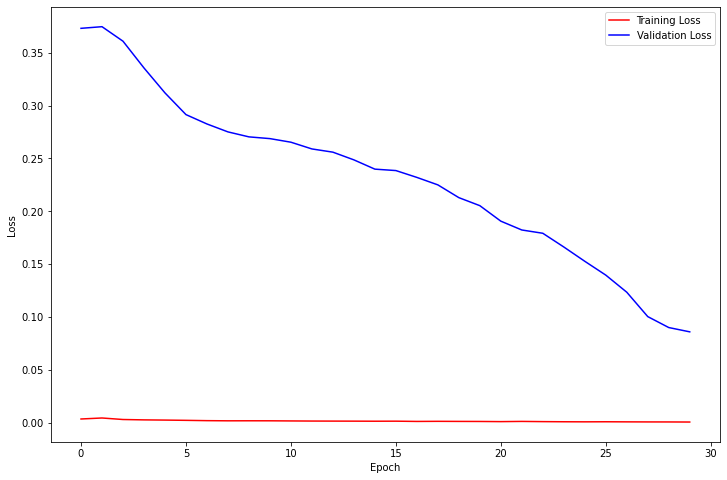

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
135,0.391848,0.188150,2022-04-21
136,0.387343,0.187872,2022-04-22
137,0.387855,0.192072,2022-04-23
138,0.382017,0.196907,2022-04-24
139,0.389802,0.199253,2022-04-25


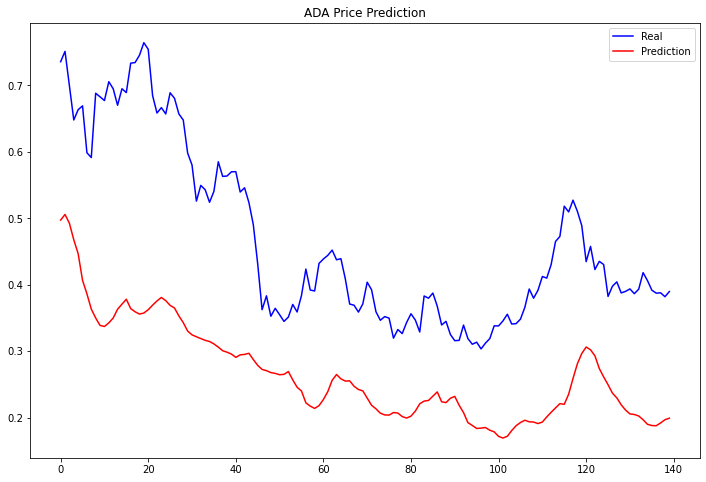

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.13256398708539466
Train data MSE:  0.017573210671976685
Train data MAE:  0.06388135614062065
-------------------------------------------------------------------------------------
Test data RMSE:  0.2133494730265879
Test data MSE:  0.045517997640722764
Test data MAE:  0.1995700005877977


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.7382354590186115
Test data R2 score: -1.586582849855847


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [22]:
data1 = sol.copy()
data1.reset_index(inplace = True)
data1.shape

(731, 8)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  731


In [24]:
data1.set_index('Date', inplace = True)
data1.shape

(731, 7)

In [25]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (584, 7)
test_data:  (147, 7)


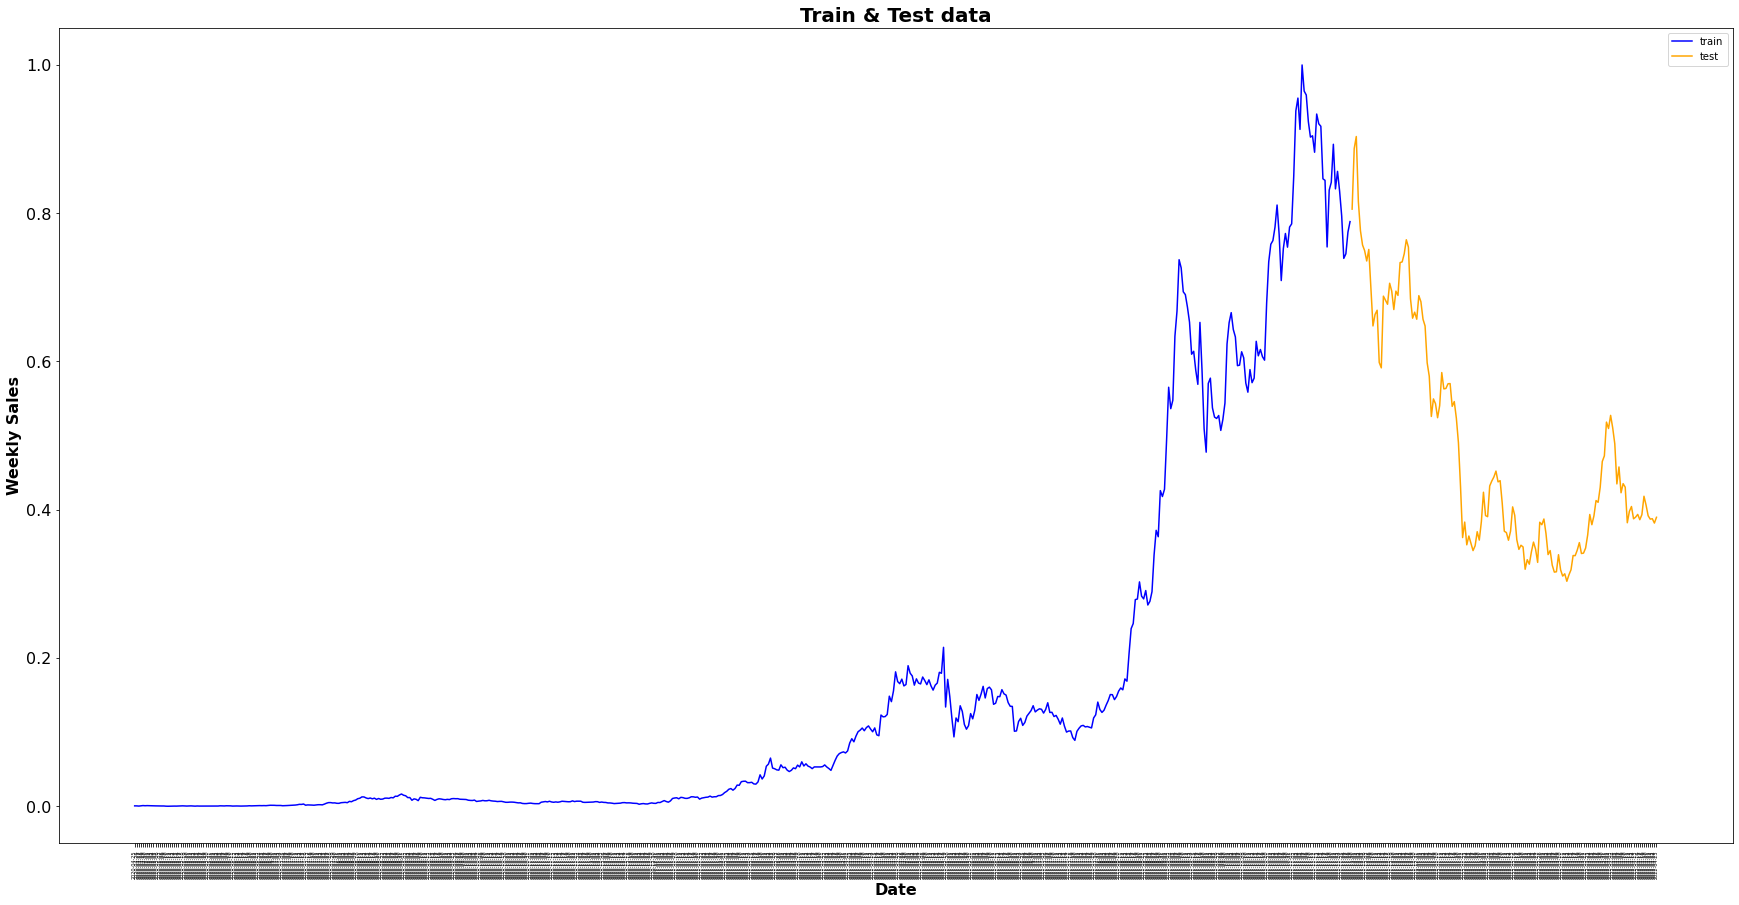

In [26]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [27]:
data1.set_index('Date', inplace = True)

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 1:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (576, 7, 6)
y_train:  (576,)
X_test:  (139, 7, 6)
y_test (139,)


In [30]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
134,0.406246,0.466196,2022-04-21
135,0.391848,0.529499,2022-04-22
136,0.387343,0.432081,2022-04-23
137,0.387855,0.345918,2022-04-24
138,0.382017,0.306542,2022-04-25


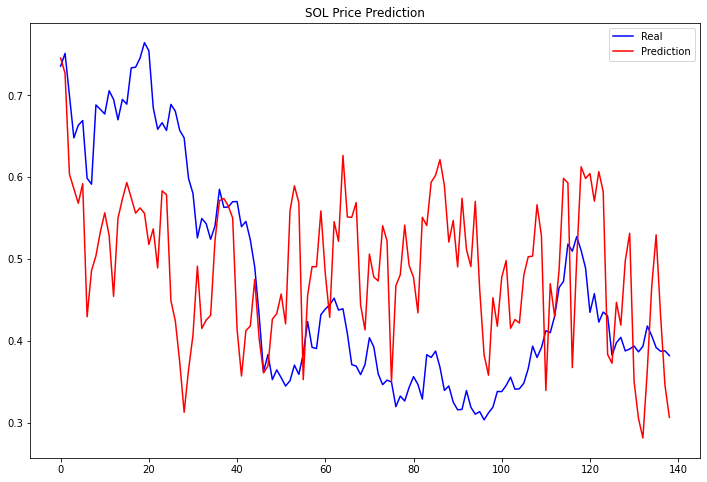

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('SOL Price Prediction')
plt.legend()
plt.show()

In [35]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.6202975979148574e-07
Mean Absolute Error - MAE : 0.0004333372962658052
Root Mean squared Error - RMSE : 0.0006016890889749337
R^2 Score 0.9999941759579045
--------------------------------------------------------------
Test data MSE:  0.019524845635203774
Mean Absolute Error - MAE : 0.11993144634284218
Root Mean squared Error - RMSE : 0.13973133376306038
R^2 Score -0.10420031596924906


# SOL- since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = sol.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [37]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume','BTC_closeprice','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [38]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [39]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [40]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [41]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [42]:
X_train.shape

(384, 7, 6)

In [43]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 77ms/step - loss: 0.0796 - val_loss: 0.3196
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 0.0557 - val_loss: 0.2177
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0564 - val_loss: 0.1696
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0546 - val_loss: 0.1399
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0461 - val_loss: 0.1052
Epoch 6/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0329 - val_loss: 0.0500
Epoch 7/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0220 - val_loss: 0.0088
Epoch 8/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0174 - val_loss: 0.0071
Epoch 9/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0152 - val_loss: 0.0106
Epoch 10/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0056
Epoch 11/

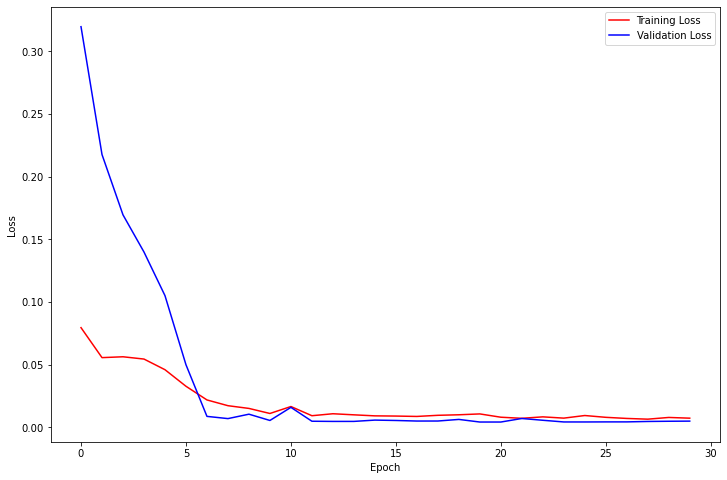

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [47]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [48]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.344855,0.452521,2022-01-27
1,0.351358,0.434436,2022-01-28
2,0.370361,0.420466,2022-01-29
3,0.359039,0.421797,2022-01-30
4,0.383964,0.416899,2022-01-31


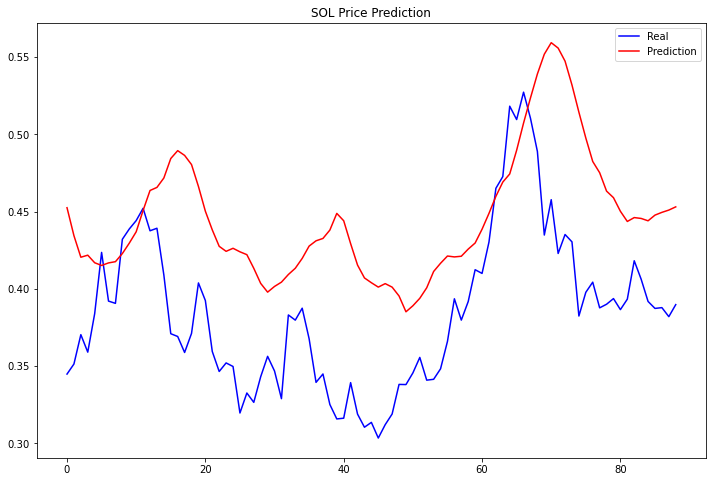

In [49]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('SOL Price Prediction')
plt.legend()
plt.show()

In [50]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.05568377844556753
Train data MSE:  0.0031006831819750513
Train data MAE:  0.04129875106144756
-------------------------------------------------------------------------------------
Test data RMSE:  0.07247484473209692
Test data MSE:  0.005252603118941558
Test data MAE:  0.0634877758648508


In [51]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.9640694149623589
Test data R2 score: -1.07659545277552


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [52]:
data3 = sol.copy()

In [53]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [54]:
data3.shape

(480, 7)

In [55]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 7)
test_data:  (96, 7)


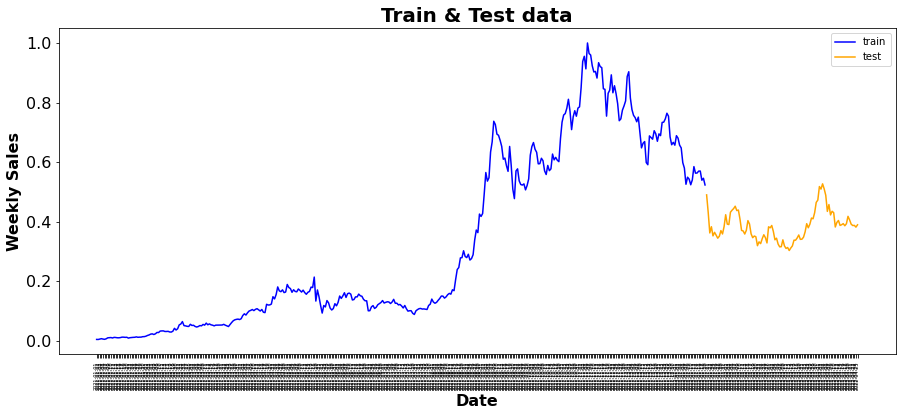

In [56]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [57]:
data3.set_index('Date', inplace = True)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 7)
y_train:  (376,)
X_test:  (88, 7, 7)
y_test (88,)


In [60]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [61]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [62]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [63]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.406246,0.574532,2022-04-21
84,0.391848,0.572900,2022-04-22
85,0.387343,0.570518,2022-04-23
86,0.387855,0.571106,2022-04-24
87,0.382017,0.570593,2022-04-25


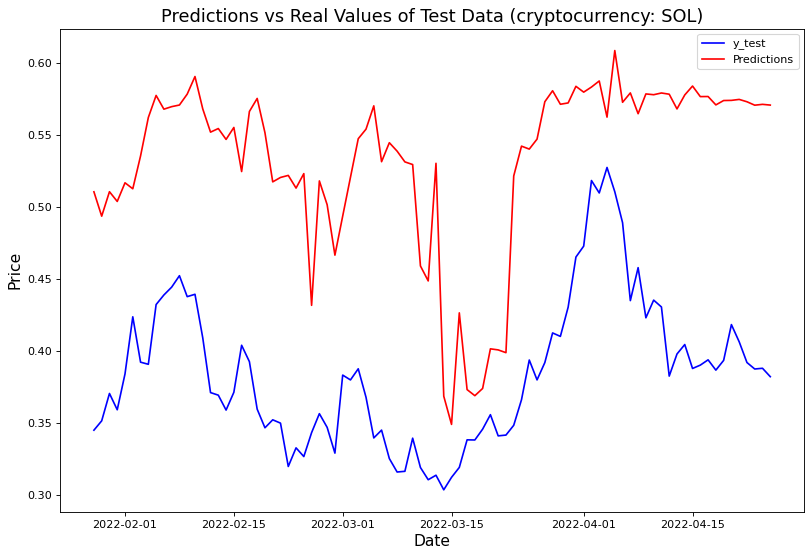

In [64]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: SOL)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [65]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.7545477280068906e-07
Mean Absolute Error - MAE : 0.00046596777964641857
Root Mean squared Error - RMSE : 0.000612743643623244
R^2 Score 0.9999957292359721
--------------------------------------------------------------
Test data MSE:  0.024048207351151516
Mean Absolute Error - MAE : 0.14721082710786526
Root Mean squared Error - RMSE : 0.15507484435314298
R^2 Score -8.401637811091398


# SOL - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [66]:
data4 = sol.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [67]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'BTC_closeprice', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [68]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [69]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [70]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [71]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [72]:
X_train.shape

(92, 7, 6)

In [73]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,6), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2160      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,297
Trainable params: 17,297
Non-trainable params: 0
_________________________________________________________________


In [74]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 269ms/step - loss: 0.1790 - val_loss: 0.1917
Epoch 2/30
3/3 [==============================] - 0s 23ms/step - loss: 0.1532 - val_loss: 0.1689
Epoch 3/30
3/3 [==============================] - 0s 22ms/step - loss: 0.1339 - val_loss: 0.1509
Epoch 4/30
3/3 [==============================] - 0s 25ms/step - loss: 0.1172 - val_loss: 0.1330
Epoch 5/30
3/3 [==============================] - 0s 21ms/step - loss: 0.1002 - val_loss: 0.1123
Epoch 6/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0810 - val_loss: 0.0888
Epoch 7/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0584 - val_loss: 0.0629
Epoch 8/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0383 - val_loss: 0.0363
Epoch 9/30
3/3 [==============================] - 0s 20ms/step - loss: 0.0198 - val_loss: 0.0140
Epoch 10/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0122 - val_loss: 0.0044
Epoch 11/30
3/3 [===========

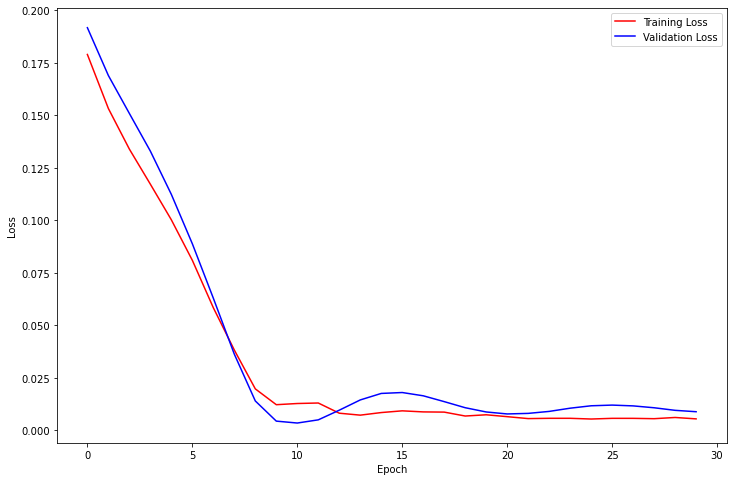

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [77]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [78]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.391848,0.331816,2022-04-21
12,0.387343,0.332856,2022-04-22
13,0.387855,0.332278,2022-04-23
14,0.382017,0.331411,2022-04-24
15,0.389802,0.332888,2022-04-25


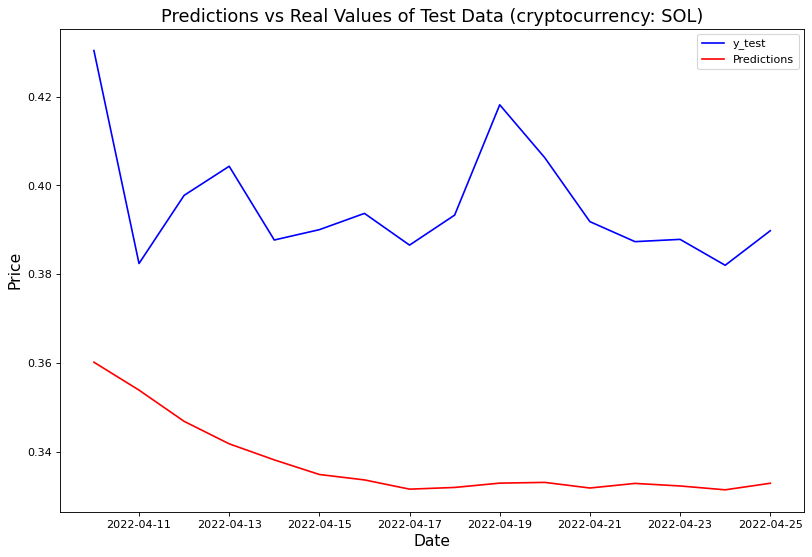

In [79]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: SOL)', fontsize = 16,)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [80]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.07391312943958268
Train data MSE:  0.0054631507035525035
Train data MAE:  0.05528590625451342
-------------------------------------------------------------------------------------
Test data RMSE:  0.059287639943610915
Test data MSE:  0.0035150242500832487
Test data MAE:  0.058092675829431034


In [81]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.06288682164820558
Test data R2 score: -20.351662128614755


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [82]:
data5= sol.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [83]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 7)
test_data:  (23, 7)


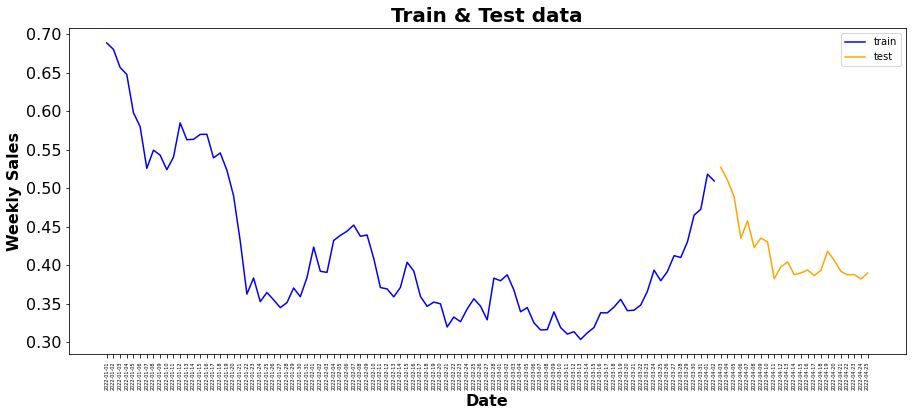

In [84]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [85]:
data5.set_index('Date', inplace = True)

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 7)
y_train:  (84,)
X_test:  (15, 7, 7)
y_test (15,)


In [88]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [89]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [90]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [91]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.406246,0.412707,2022-04-21
11,0.391848,0.412614,2022-04-22
12,0.387343,0.421355,2022-04-23
13,0.387855,0.395204,2022-04-24
14,0.382017,0.397078,2022-04-25


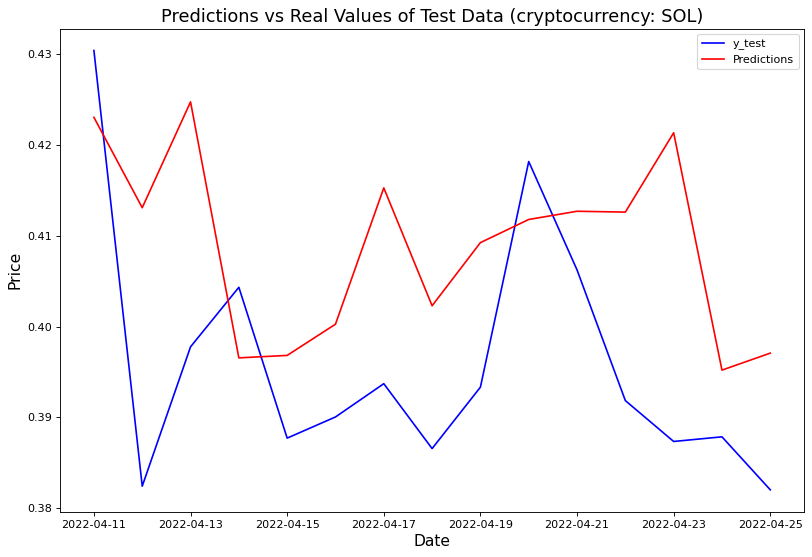

In [92]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: SOL)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [93]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.8440656376694762e-07
Mean Absolute Error - MAE : 0.00030338463752139393
Root Mean squared Error - RMSE : 0.00042942585363127313
R^2 Score 0.9999679898308791
--------------------------------------------------------------
Test data MSE:  0.0003259918167779372
Mean Absolute Error - MAE : 0.01569369436023417
Root Mean squared Error - RMSE : 0.01805524347046966
R^2 Score -0.8820478399315208


# Predictions for the next two days using the best model <a name="predictions"></a>

In [94]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_SOL.csv', index_col = 'Date')

In [95]:
predictions.tail(7)

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2022-05-02,0.336917,0.074090,0.138608,0.055483,0.888437,0.017292,0.516017
2022-05-03,0.330189,0.059253,0.148174,0.031030,0.898003,0.002644,0.503035
2022-05-04,0.357000,0.083654,0.192404,0.093875,0.994037,0.013245,0.535502
2022-05-05,0.325366,0.105773,0.177967,0.183266,0.625890,0.064389,0.483445
2022-05-06,0.314407,0.092830,0.161085,0.040830,0.896664,0.019347,0.474541
2022-05-07,0.303647,0.066700,0.046308,0.045681,0.885390,0.019347,0.465558
2022-05-08,0.290308,0.084771,0.013549,0.054827,0.868867,0.019347,0.444304


In [96]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [97]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [98]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.33691689 0.07409004 0.13860764 0.05548303 0.88843704 0.01729174
 0.5160166  0.3301889  0.05925341 0.14817439 0.03103035 0.89800301
 0.00264389 0.50303467 0.35699991 0.08365386 0.19240371 0.09387481
 0.99403737 0.01324543 0.53550166 0.32536591 0.10577269 0.1779668
 0.1832659  0.62589044 0.06438862 0.48344512 0.31440729 0.09283048
 0.16108453 0.04083004 0.89666434 0.01934702 0.47454101 0.30364692
 0.06670036 0.04630795 0.04568101 0.88538968 0.01934702 0.46555773
 0.29030842 0.0847713  0.01354908 0.05482738 0.86886672 0.01934702
 0.44430403]
0 day output [0.44386292]
Output of predicted next days:  1


In [99]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.4438629150390625]

In [100]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [101]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [102]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
0,2022-05-08,0.290308,0.084771,0.013549,0.054827,0.868867,0.019347,0.444304


In [103]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2022-05-09,0.443863,0.084771,0.013549,0.054827,0.868867,0.019347,0.444304


In [104]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [105]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((258.934326-0.515273)*output9[0])+0.515273

print ("The predicted closing price for SOL on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for SOL on May 9th, 2022 is  115.21790716621399 USD


# Final Predictions<a name="finalpredictions"></a>

In [106]:
final_predictions.tail(7)

,close,volume,%D,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,
2022-05-03,0.330189,0.059253,0.148174,0.031030,0.898003,0.002644,0.503035
2022-05-04,0.357000,0.083654,0.192404,0.093875,0.994037,0.013245,0.535502
2022-05-05,0.325366,0.105773,0.177967,0.183266,0.625890,0.064389,0.483445
2022-05-06,0.314407,0.092830,0.161085,0.040830,0.896664,0.019347,0.474541
2022-05-07,0.303647,0.066700,0.046308,0.045681,0.885390,0.019347,0.465558
2022-05-08,0.290308,0.084771,0.013549,0.054827,0.868867,0.019347,0.444304
2022-05-09,0.443863,0.084771,0.013549,0.054827,0.868867,0.019347,0.444304


In [107]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [108]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [109]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.3301889  0.05925341 0.14817439 0.03103035 0.89800301 0.00264389
 0.50303467 0.35699991 0.08365386 0.19240371 0.09387481 0.99403737
 0.01324543 0.53550166 0.32536591 0.10577269 0.1779668  0.1832659
 0.62589044 0.06438862 0.48344512 0.31440729 0.09283048 0.16108453
 0.04083004 0.89666434 0.01934702 0.47454101 0.30364692 0.06670036
 0.04630795 0.04568101 0.88538968 0.01934702 0.46555773 0.29030842
 0.0847713  0.01354908 0.05482738 0.86886672 0.01934702 0.44430403
 0.44386292 0.0847713  0.01354908 0.05482738 0.86886672 0.01934702
 0.44430403]
0 day output [0.44555867]
Output of predicted next days:  1


In [110]:
print ("The predicted normalized closing price for SOL on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for SOL on May 10th, 2022 is  0.44555866718292236


In [111]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((258.934326-0.515273)*output10[0])+0.515273

print ("The predicted closing price for SOL on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for SOL on May 10th, 2022 is  115.65612182935298 USD
